### COVID-19 Classification with Focal Loss

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip"

### Load chest x-ray dataset

In [0]:
data_dir = '/content/A_05_Part_02_Dataset'

In [32]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [5]:
print(train_data.class_to_idx)

{'covid-19': 0, 'normal': 1, 'pneumonia': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


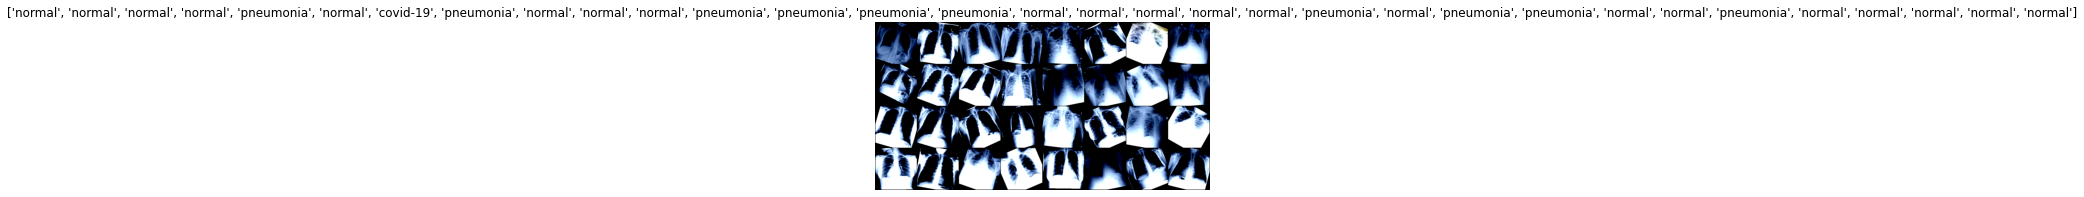

In [34]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Compute loss and accuracy

In [0]:
def get_encoded_labels_for_class(label):
  if label == 0:
      # COVID-19 Class
    one_hot_encoded_labels = [1, 0, 1]
  elif label == 1:
    # Normal Class
    one_hot_encoded_labels = [0, 1, 0]
  else:
    # Pneumonia Class
    one_hot_encoded_labels = [0, 0, 1]
  return one_hot_encoded_labels

# def get_class_for_encoded_labels(label):
#   if label == [1, 0, 1]:
#     return 0
#   elif label == [0, 1, 0]:
#     return 1
#   elif label == [0, 0, 1]:
#     return 2
#   return -1

In [0]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
def compute_loss_and_accuracy(loader, model):
  loss = 0
  correct_labels = []
  predicted_labels = []
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
  
          outputs = model(images)

          predicted = []
          for predicted_output in outputs.data:
            predicted_output = torch.sigmoid(predicted_output)
            thresholded_vector = (predicted_output >= 0.5).int()
            # predicted.append(get_class_for_encoded_labels(thresholded_vector))
            predicted.append(thresholded_vector.tolist())

          predicted_labels.extend(predicted)

          one_hot_encoded_labels = []
          for label in labels:
            one_hot_encoded_labels.append(get_encoded_labels_for_class(label))

          correct_labels.extend(one_hot_encoded_labels)

          one_hot_encoded_labels = torch.FloatTensor(one_hot_encoded_labels)
          one_hot_encoded_labels = one_hot_encoded_labels.to(device)

          loss += criterion(outputs, one_hot_encoded_labels).item()

  conf_matrix = multilabel_confusion_matrix(correct_labels, predicted_labels)
  f1 = f1_score(correct_labels, predicted_labels, average='weighted')
  return loss, conf_matrix, f1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Function to plot confusion matrix using seaborn (https://github.com/DTrimarchi10/confusion_matrix)

In [0]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    blanks = ['' for i in range(cf.size)]
    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')
  
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Training function

In [0]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn

def train_model(model, Epochs, criterion, optimizer, output_file, loss_item=True):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.train()

    loss_per_iter_train = []
    f1_per_iter_train = []

    loss_per_iter_validation = []
    f1_per_iter_validation = []

    epochs = range(Epochs)
    for epoch in epochs:  # loop over the dataset multiple times

        running_loss = 0.0
        pbar = tqdm(enumerate(trainloader))

        correct_labels = []
        predicted_labels = []

        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            one_hot_encoded_labels = []
            for label in labels:
              one_hot_encoded_labels.append(get_encoded_labels_for_class(label))

            correct_labels.extend(one_hot_encoded_labels)

            one_hot_encoded_labels = torch.FloatTensor(one_hot_encoded_labels)
            one_hot_encoded_labels = one_hot_encoded_labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = criterion(outputs, one_hot_encoded_labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()

            predicted = []
            for predicted_output in outputs.data:
              thresholded_vector = (predicted_output >= 0.5).int()
              predicted.append(thresholded_vector.tolist())

            predicted_labels.extend(predicted)
            
            if loss_item:
              loss = loss.item()
  
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    loss))
            
        loss_per_iter_train.append(running_loss)
        f1 = sklearn.metrics.f1_score(correct_labels, predicted_labels, average='weighted')
        f1_per_iter_train.append(f1)

        print('Train F1 score: {} %'.format(f1))

        validation_loss, conf_matrix, validation_f1 = compute_loss_and_accuracy(validationloader, model)
        loss_per_iter_validation.append(validation_loss)
        f1_per_iter_validation.append(validation_f1)

        print('Validation F1 score: {} %'.format(validation_f1))


    plt.grid()
    plt.plot(epochs, f1_per_iter_validation, 'o-', color="r",
                  label="F1 score per iteration validation")
    plt.plot(epochs, f1_per_iter_train, 'o-', color="g",
                  label="F1 score per iteration train")
    plt.legend(loc="best")
    plt.show()

    plt.grid()
    plt.plot(epochs, loss_per_iter_validation, 'o-', color="r",
                  label="Loss per iteration validation")
    plt.plot(epochs, loss_per_iter_train, 'o-', color="g",
                  label="Loss per iteration train")
    plt.legend(loc="best")
    plt.show()

    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['Zero', 'One']

    train_loss, conf_matrix,  f1_score = compute_loss_and_accuracy(trainloader, model)
    print('Train F1 Score: ', f1_score)
    print('Training Confusion Matrices')
    make_confusion_matrix(conf_matrix[0], group_names=labels, categories=categories, title='COVID-19 (Training)')
    make_confusion_matrix(conf_matrix[1], group_names=labels, categories=categories, title='Normal (Training)')
    make_confusion_matrix(conf_matrix[2], group_names=labels, categories=categories, title='Pneumonia (Training)')

    validation_loss,  conf_matrix, f1_score = compute_loss_and_accuracy(validationloader, model)
    print('Validation F1 Score: ', f1_score)
    print('Validation Confusion Matrices')
    make_confusion_matrix(conf_matrix[0], group_names=labels, categories=categories, title='COVID-19 (Validation)')
    make_confusion_matrix(conf_matrix[1], group_names=labels, categories=categories, title='Normal (Validation)')
    make_confusion_matrix(conf_matrix[2], group_names=labels, categories=categories, title='Pneumonia (Validation)')

    torch.save(model.state_dict(), output_file)
    print('Finished Training')

## Task 1 (without focal loss)

### VGG


Train F1 score: 0.7785935017606505 %
Validation F1 score: 0.8590028832152117 %



Train F1 score: 0.8768740379559483 %
Validation F1 score: 0.8867240227028618 %



Train F1 score: 0.8881105627416466 %
Validation F1 score: 0.8713194356860006 %



Train F1 score: 0.8975917790424984 %
Validation F1 score: 0.8962665694896077 %


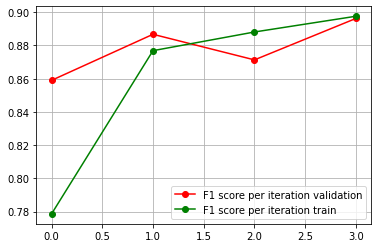

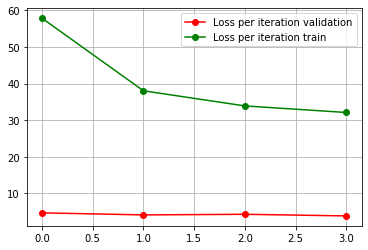

Train F1 Score:  0.9199051012918631
Training Confusion Matrices
Validation F1 Score:  0.8997599501940725
Validation Confusion Matrices
Finished Training


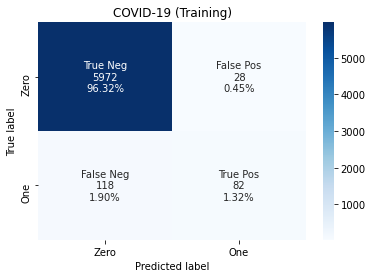

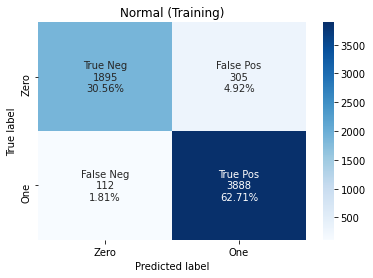

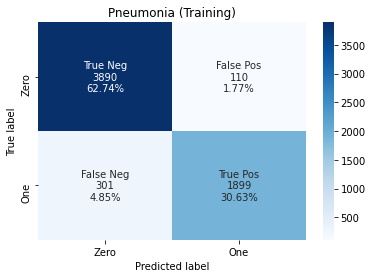

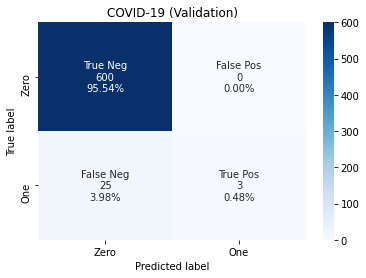

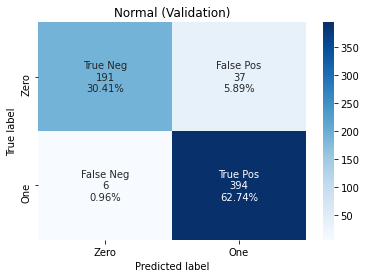

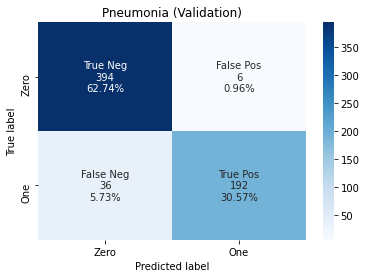

In [40]:
vgg16_task1 = models.vgg16(pretrained=True)

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16_task1.classifier = nn.Sequential(*features)

output_file='vgg16task1.pth'

Epochs = 4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16_task1.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16_task1, Epochs, criterion,  optimizer, output_file)

In [0]:
!cp "/content/vgg16task1.pth" "./gdrive/My Drive/Colab Notebooks/2vgg16task1.pth"

### RESNET-18


Train F1 score: 0.5460799964524855 %
Validation F1 score: 0.789357662228362 %



Train F1 score: 0.8315272082288001 %
Validation F1 score: 0.8551107812174847 %



Train F1 score: 0.8641143372506557 %
Validation F1 score: 0.8705448932748844 %



Train F1 score: 0.882833673852312 %
Validation F1 score: 0.8736127149688158 %


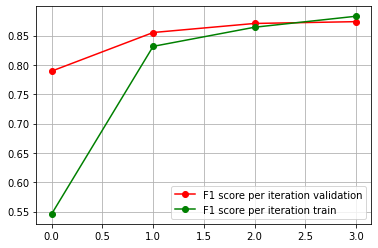

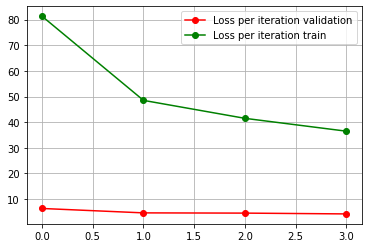

Train F1 Score:  0.8899897141794785
Training Confusion Matrices
Validation F1 Score:  0.8701327206711932
Validation Confusion Matrices
Finished Training


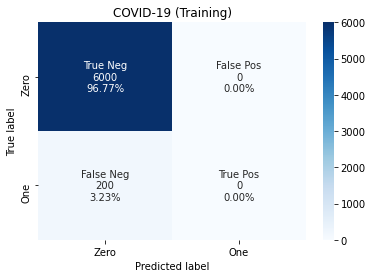

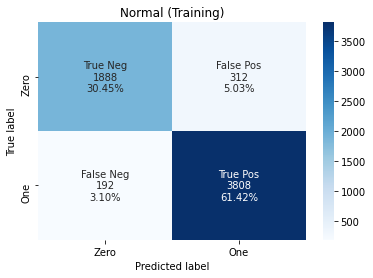

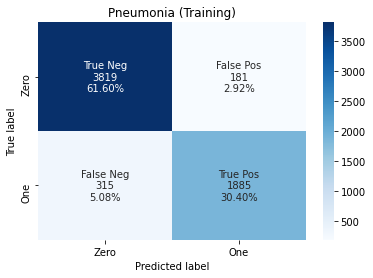

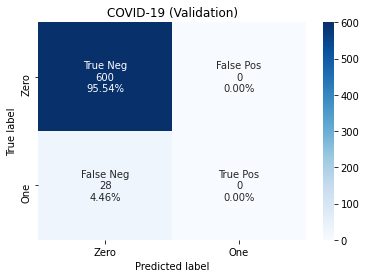

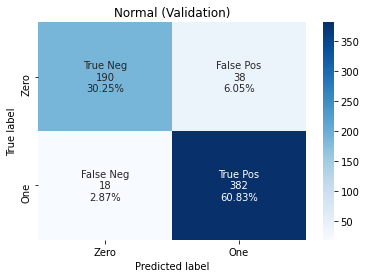

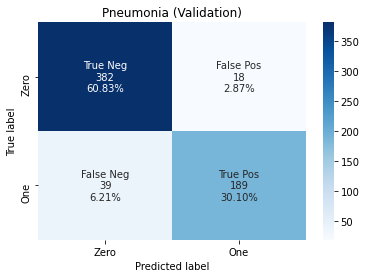

In [42]:
resnet18_task1 = models.resnet18(pretrained=True)
'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
resnet18_task1.fc = nn.Sequential(*features)

output_file='resnet18task1.pth'

Epochs = 4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18_task1.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18_task1, Epochs, criterion,  optimizer, output_file)


In [0]:
!cp "/content/resnet18task1.pth" "./gdrive/My Drive/Colab Notebooks/2res18_task1.pth"

## Task 2 (with focal loss)

In [0]:
gamma = 2
alpha = 0.5
def focal_loss(output, one_hot_encoded_vector):
    # Focal loss as defined in the paper: FL(p_t) = −(1 − p_t)^γ log(p_t).
    # Here, log(p_t) is actually the cross entropy before normalization (i.e. bce loss)
    # and p_t can be computed as e^log(p_t) => p_t
    cross_entropy = torch.nn.functional.binary_cross_entropy_with_logits(
        output,
        one_hot_encoded_vector,
        reduce=False
    )
    p_t = torch.exp(-cross_entropy)
    F_loss = torch.mean(
        alpha * (1 - p_t)**gamma * cross_entropy
    )
    return F_loss

### VGG

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Train F1 score: 0.6145829439065161 %
Validation F1 score: 0.8217461863031483 %



Train F1 score: 0.7887431748079482 %
Validation F1 score: 0.8430605197025007 %



Train F1 score: 0.8334831628982622 %
Validation F1 score: 0.8675055288995772 %



Train F1 score: 0.8429975448788934 %
Validation F1 score: 0.8654242902795282 %



Train F1 score: 0.8494555492924245 %
Validation F1 score: 0.876109289623101 %



Train F1 score: 0.858548461580073 %
Validation F1 score: 0.890435049019224 %



Train F1 score: 0.8633436082411646 %
Validation F1 score: 0.8887698524760236 %



Train F1 score: 0.8694150508508096 %
Validation F1 score: 0.8866593205673329 %



Train F1 score: 0.8745128101287177 %
Validation F1 score: 0.890110186562208 %



Train F1 score: 0.8792779524864011 %
Validation F1 score: 0.900333351092126 %


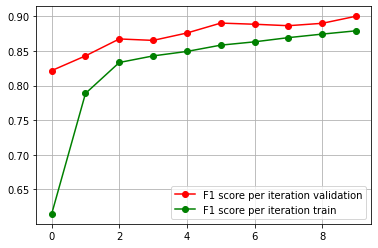

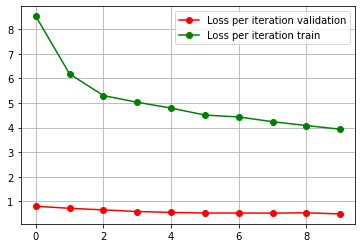

Train F1 Score:  0.9199951678841747
Training Confusion Matrices
Validation F1 Score:  0.8935035954665842
Validation Confusion Matrices
Finished Training


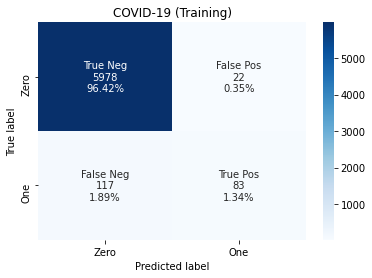

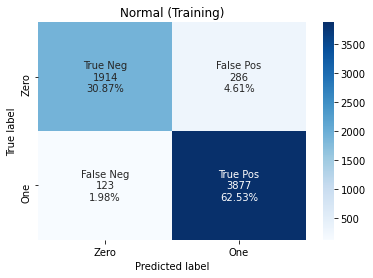

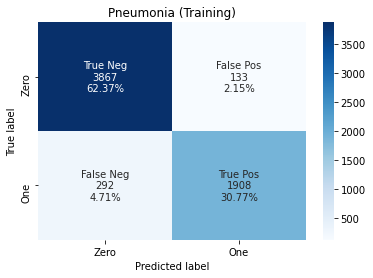

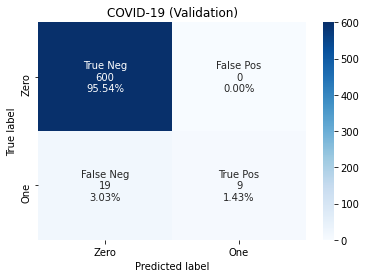

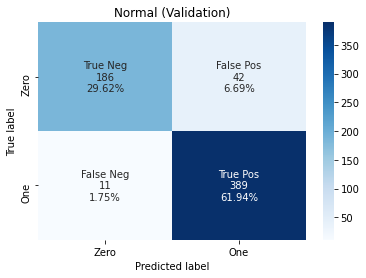

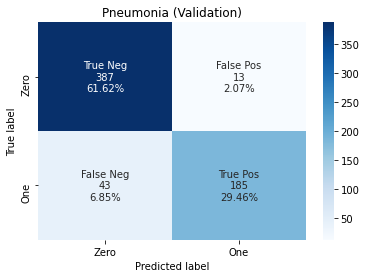

In [45]:
vgg16_task2 = models.vgg16(pretrained=True)

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(25088, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
vgg16_task2.classifier = nn.Sequential(*features)

output_file='vgg16task2.pth'

Epochs = 10
criterion =  focal_loss
optimizer = optim.SGD(vgg16_task2.parameters(), lr=0.001, momentum=0.9)
train_model(vgg16_task2, Epochs, criterion, optimizer, output_file, loss_item=False)

In [0]:
!cp "/content/vgg16task2.pth" "./gdrive/My Drive/Colab Notebooks/2vgg16_focal_loss.pth"

### RESNET-18

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Train F1 score: 0.22978823889727518 %
Validation F1 score: 0.6699477498711143 %



Train F1 score: 0.3884094781642672 %
Validation F1 score: 0.7553147931084313 %



Train F1 score: 0.5342532717533094 %
Validation F1 score: 0.8039835863099065 %



Train F1 score: 0.668738997934514 %
Validation F1 score: 0.8245942958089189 %



Train F1 score: 0.7421117201601446 %
Validation F1 score: 0.8338769312359572 %



Train F1 score: 0.7756352216048839 %
Validation F1 score: 0.8457053867427712 %



Train F1 score: 0.7941427893187064 %
Validation F1 score: 0.8639668542067335 %



Train F1 score: 0.8096626473005305 %
Validation F1 score: 0.8551899615116424 %



Train F1 score: 0.8276277414509644 %
Validation F1 score: 0.8497115280200239 %



Train F1 score: 0.8304493894119966 %
Validation F1 score: 0.8655921445578093 %


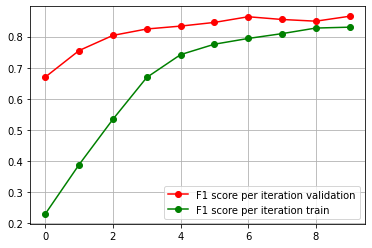

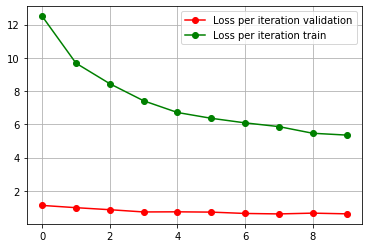

Train F1 Score:  0.8777838873752971
Training Confusion Matrices
Validation F1 Score:  0.8636452352465427
Validation Confusion Matrices
Finished Training


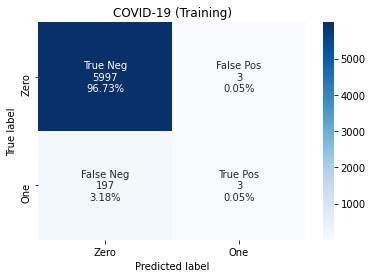

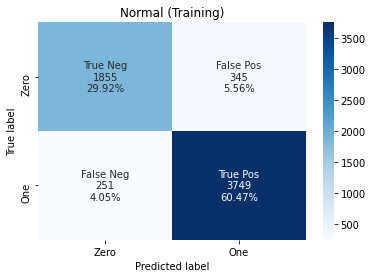

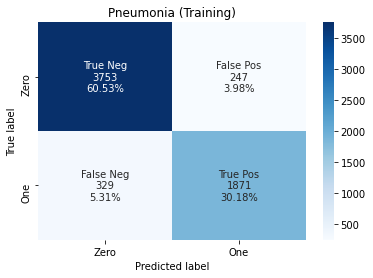

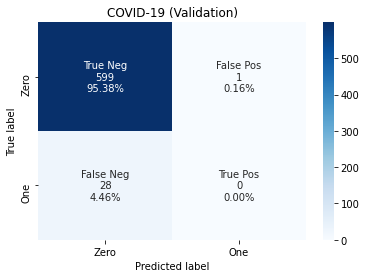

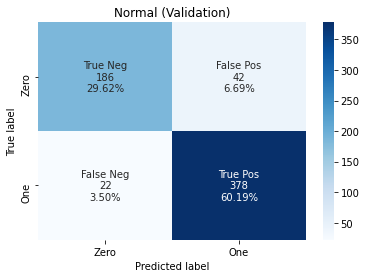

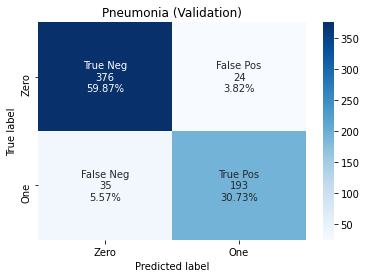

In [47]:
resnet18_task2 = models.resnet18(pretrained=True)

'''
  Replace FC layers with two FC layers
'''
features= []
features.extend([nn.Linear(512, 130), nn.ReLU(inplace=True), nn.Dropout()])
features.extend([nn.Linear(130, len(class_names))])
resnet18_task2.fc = nn.Sequential(*features)

output_file='resnet18_task2.pth'

Epochs = 10
criterion =  focal_loss
optimizer = optim.SGD(resnet18_task2.parameters(), lr=0.001, momentum=0.9)
train_model(resnet18_task2, Epochs, criterion,  optimizer, output_file)


In [0]:
!cp "/content/resnet18_task2.pth" "./gdrive/My Drive/Colab Notebooks/2res18_focal_loss.pth"

In [49]:
!mkdir "/content/test_data"

mkdir: cannot create directory ‘/content/test_data’: File exists


In [0]:
!cp -r "/content/A_05_Part_02_Dataset/Test" "/content/test_data"

In [0]:
## Image Folder with Paths . Acknowledgment: Andrew Jong https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_data = ImageFolderWithPaths('/content/test_data', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

### Predict labels for test data

In [52]:
import os
results = []
with torch.no_grad():
    predicted_labels = []
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_task2(images)

        for predicted_output, path in zip(outputs.data, paths):
          predicted = []
          predicted.append(os.path.basename(path))
  
          predicted_output = torch.sigmoid(predicted_output)
          thresholded_vector = (predicted_output >= 0.5).int()

          thresholded_vector = thresholded_vector.tolist()
          
          # the order in which hidden results are present
          thresholded_vector[1], thresholded_vector[2] = thresholded_vector[2], thresholded_vector[1]
          predicted.extend(thresholded_vector)
          
          predicted_labels.append(predicted)

    print(predicted_labels)
        
          


[['407.png', 0, 0, 1], ['262.png', 0, 1, 0], ['17.png', 0, 1, 0], ['203.png', 0, 0, 1], ['425.png', 0, 0, 1], ['356.png', 0, 1, 0], ['38.png', 0, 0, 1], ['204.png', 0, 1, 0], ['472.png', 0, 1, 0], ['87.png', 0, 1, 0], ['55.png', 0, 0, 1], ['573.png', 0, 0, 1], ['2.png', 0, 1, 0], ['155.png', 0, 0, 1], ['406.png', 0, 0, 1], ['157.png', 0, 0, 1], ['76.png', 0, 1, 0], ['235.png', 0, 0, 1], ['618.png', 0, 0, 1], ['467.png', 0, 0, 1], ['498.png', 0, 1, 0], ['60.png', 0, 0, 1], ['30.png', 0, 0, 1], ['132.png', 0, 1, 0], ['354.png', 0, 0, 1], ['0.png', 0, 0, 1], ['463.png', 0, 1, 0], ['347.png', 0, 0, 1], ['295.png', 0, 1, 0], ['118.png', 0, 0, 1], ['176.png', 0, 0, 1], ['168.png', 0, 0, 1], ['464.png', 0, 0, 1], ['33.png', 0, 0, 1], ['166.png', 0, 0, 1], ['179.png', 0, 0, 1], ['398.png', 0, 1, 0], ['144.png', 0, 0, 1], ['6.png', 0, 0, 1], ['478.png', 0, 0, 1], ['578.png', 0, 0, 1], ['627.png', 0, 1, 0], ['79.png', 0, 0, 1], ['249.png', 0, 0, 1], ['380.png', 0, 0, 1], ['119.png', 0, 1, 0], ['

### Store the results in a csv

In [0]:
import pandas as pd
df = pd.DataFrame(predicted_labels)
df.to_csv('msds19003_results.csv', index=False, header=False)

In [0]:
!cp "/content/msds19003_results.csv" "./gdrive/My Drive/Colab Notebooks/msds19003_results.csv"